In [1]:
import os
import numpy as np
import glob
import pickle
import seaborn as sns
import matplotlib.ticker as ticker
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import utils

In [2]:
# allows for automatic setting of x ticks
def format_fn(tick_val, tick_pos):
    if int(tick_val) in x_tick_indices:
        return tvec[int(tick_val)]
    else:
        return ''

def format_xy_axes(ax_handle):
    ax_handle.xaxis.set_major_formatter(ticker.FuncFormatter(format_fn))
    ax_handle.xaxis.set_major_locator(ticker.AutoLocator())
    ax_handle.yaxis.set_major_locator(ticker.AutoLocator())
    ax_handle.yaxis.set_major_formatter(ticker.ScalarFormatter())
    
# simple class to update limits as you go through iterations of data
class update_lims:
    
    def __init__(self, lims):
        self.lims = lims
        
    
    def update(self, new_lims):
        if self.lims[0] > new_lims[0]:
            self.lims[0] = new_lims[0]
        
        if self.lims[1] < new_lims[1]:
            self.lims[1] = new_lims[1]

    def output(self):
        return self.lims

In [3]:
# declare some fixed constant variables
axis_label_size = 15

In [4]:
# indicate a file to analyze
fname = 'VJ_OFCVTA_7_260_D6'
fdir = r'C:\2pData\Vijay data\VJ_OFCVTA_7_D8_trained'
flag_npil_corr = False # declare which data to load in
flag_zscore = True # whether or not to z-score data for plots

# set the sampling rate
fs = 5

if flag_npil_corr == True:
    signals_fpath = os.path.join(fdir, "{}_neuropil_corrected_signals*".format(fname))
    
elif flag_npil_corr == False:
    signals_fpath = os.path.join(fdir, "*_extractedsignals*")

save_path = os.path.join(fdir, 'event_rel_analysis_' + fname)

utils.check_exist_dir(save_path) # make the save directory

'C:\\2pData\\Vijay data\\VJ_OFCVTA_7_D8_trained\\event_rel_analysis_VJ_OFCVTA_7_260_D6'

In [5]:
# trial windowing 
trial_start_end_sec = np.array([-4, 10]) # trial windowing in seconds relative to ttl-onset/trial-onset
baseline_start_end_sec = np.array([trial_start_end_sec[0], -0.5])

# convert times to samples and get sample_vector
trial_begEnd_samp = trial_start_end_sec*fs # turn trial start/end times to samples
trial_svec = np.arange(trial_begEnd_samp[0], trial_begEnd_samp[1])
baseline_begEnd_samp = baseline_start_end_sec*fs
baseline_svec = (np.arange(baseline_begEnd_samp[0], baseline_begEnd_samp[1]+1, 1) - baseline_begEnd_samp[0]).astype('int')

num_samples_trial = len( trial_svec )
tvec = np.round(np.linspace(trial_start_end_sec[0], trial_start_end_sec[1], num_samples_trial+1), 1)

x_tick_indices = range(len(tvec))

In [6]:
# load time-series data
glob_signal_files = glob.glob(signals_fpath)
if len(glob_signal_files) == 1:
    signals = np.squeeze(np.load(glob_signal_files[0]))
else:
    print('Warning: No or multiple signal files detected; using first detected file')

num_rois = signals.shape[0]
    
#load behavioral data and trial info
try:
    glob_frame_files = glob.glob(os.path.join(fdir, "framenumberforevents_{}_*".format(fname))) # look for a file in specified directory
    event_frames = pickle.load( open( glob_frame_files[0], "rb" ) ) # latin1 b/c original pickle made in python 2

except:
    print('Cannot find behavioral data file or file path is incorrect; utils.extract_trial_data will throw error.')
    
all_conditions = event_frames.keys()
conditions = [ all_conditions[i] for i in [0, 4, 6] ] # __ USER DEFINE

In [7]:
# extract trial data
data_dict = utils.extract_trial_data(signals, trial_begEnd_samp, event_frames, 
                                     conditions, baseline_start_end_samp = baseline_begEnd_samp)

In [8]:
# def calculate_dict_clims(dict, flag_zscore_=False) __

# for trial_avg data, get min/max across conditions
clims_data = [ np.nanmin( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ), 
        np.nanmax( [np.mean(data_dict[key]['data'], axis = 0) for key in data_dict] ) ]

# for z-scored data, we'd like for the color scale to be centered at 0; first we get color limits
tmp_clim = [ np.nanmin( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ), 
        np.nanmax( [data_dict[key]['ztrial_avg_data'] for key in data_dict] ) ]
# then we take the higher of the two magnitudes
clims_max = np.max(np.abs(tmp_clim))
# and set it as the negative and positive limit for plotting
clims_z = [-clims_max*0.6, clims_max*0.6]

## Plot trial-resolved heatmap for each ROI

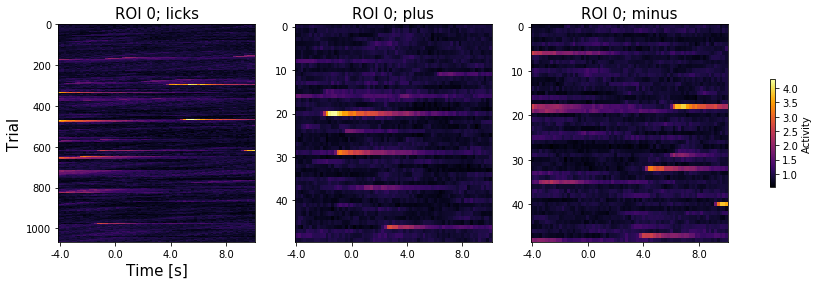

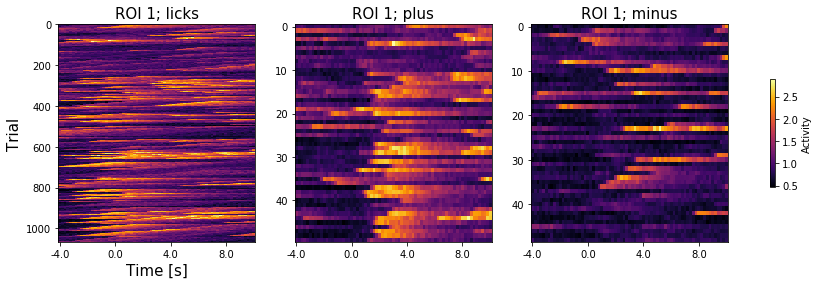

In [20]:
n_columns = 3.0
num_subplots = len(conditions)
n_rows = int(np.ceil(num_subplots/n_columns))

for iROI in range(2):
 
    roi_clims = [ np.nanmin( [np.nanmin(data_dict[cond]['data'][:,iROI,:]) for cond in conditions] ), 
        np.nanmax( [np.nanmax(data_dict[cond]['data'][:,iROI,:]) for cond in conditions] ) ]
    
    fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), figsize = (15, n_rows*4))
    
    for idx_cond, cond in enumerate(conditions):
        
        # determine subplot location index
        if n_rows == 1:
            subplot_index = idx_cond
        else:
            subplot_index = np.unravel_index(idx, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates
        
        # plot x and y labels for first subplot
        if subplot_index == (0, 0) or subplot_index == 0 :
            ax[subplot_index].set_ylabel('Trial', fontsize=axis_label_size)
            ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);
        
        # plot the data
        to_plot = np.squeeze(data_dict[cond]['data'][:,iROI,:]) 
        title = 'ROI {}; {}'.format(str(iROI), cond)
        im = utils.subplot_heatmap(ax[subplot_index], title, to_plot, cmap='inferno', clims=roi_clims)
        format_xy_axes(ax[subplot_index])
        
    cbar = fig.colorbar(im, ax = ax, shrink = 0.5)
    cbar.ax.set_ylabel('Activity')

## Plot trial-avged heatmaps (ROI by trial-avg time by activity)

Text(0,0.5,'Z-Score Activity')

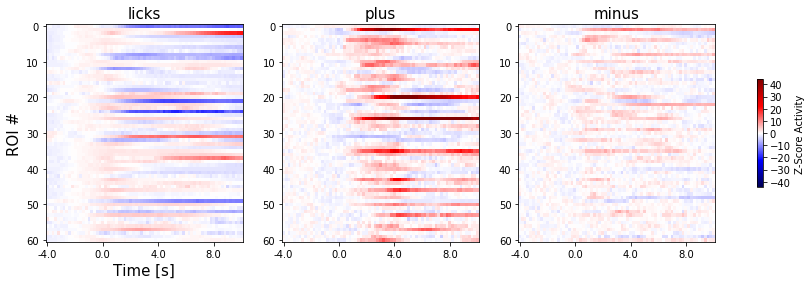

In [21]:
n_columns = 3.0
num_subplots = len(conditions)
n_rows = int(np.ceil(num_subplots/n_columns))

fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), figsize = (15, n_rows*4))
for idx, cond in enumerate(conditions):
    
    # determine subplot location index
    if n_rows == 1:
        subplot_index = idx
    else:
        subplot_index = np.unravel_index(idx, (n_rows, int(n_columns))) # turn int index to a tuple of array coordinates
    
    # plot x and y labels for first subplot
    if subplot_index == (0, 0) or subplot_index == 0 :
        ax[subplot_index].set_ylabel('ROI #', fontsize=axis_label_size)
        ax[subplot_index].set_xlabel('Time [s]', fontsize=axis_label_size);
    
    # plot the data
    to_plot = data_dict[cond]['ztrial_avg_data'] # np.mean( data_dict[cond]['data'], axis=0) #
        
    im = utils.subplot_heatmap(ax[subplot_index], cond, to_plot, clims = clims_z)
    format_xy_axes(ax[subplot_index])
    
cbar = fig.colorbar(im, ax = ax, shrink = 0.5)
cbar.ax.set_ylabel('Z-Score Activity')

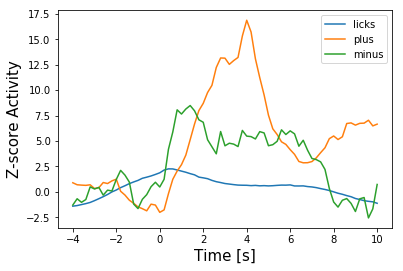

In [22]:
for cond in conditions:
    roi_trial_avg = np.mean(data_dict[cond]['data'], axis = (0, 1))
    
    zscore_roi_trial_avg = utils.zscore_(roi_trial_avg, baseline_svec)

    sns.lineplot(tvec, np.squeeze(zscore_roi_trial_avg))
    
plt.ylabel('Z-score Activity', fontsize=axis_label_size)
plt.xlabel('Time [s]', fontsize=axis_label_size);
plt.legend(conditions)

## Plot each neuron's trial averaged response across conditions

In [ ]:
n_columns = 3.0
num_subplots = len(conditions)
n_rows = int(np.ceil(num_subplots/n_columns))

fig, ax = plt.subplots(nrows=n_rows, ncols=int(n_columns), figsize = (15, n_rows*4))

In [ ]:
event_frames = {}
event_frames['slm_stim'] = np.array([300.])

with open(r'D:\20200410_gcamp_chrmine\vj_ofc_imageactivate_01_300_stim-013\framenumberforevents_vj_ofc_imageactivate_01_300_stim-013.pickle', 'wb') as handle:
    pickle.dump(event_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)